Packages installieren und Daten einlesen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
import os
import math

os.chdir("C:/Users/phaim/OneDrive/Applied Data Science/Fallstudie")

data_lgd = pd.read_csv("LGD_Panel.csv")

Unnötige Beobachtungen löschen: Beobachtungen welche kein Ausfallereignis sind oder deren Ausfall noch nicht abgeschlossen ist

In [4]:
data_lgd = data_lgd[data_lgd['default_time'] == 1]
data_lgd = data_lgd.dropna(subset = ['res_time'])


data_lgd.head()


,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res
263,191,31,23,26,143,38.0,223884.74,87.176730,7.360,4.39,...,630,80.0,7.360,FL,221.91,1,0,1,0.883919,25988.76
356,330,33,27,28,147,43.0,144374.85,98.272701,9.045,4.71,...,613,80.0,9.045,FL,222.39,1,0,1,1.236213,-34103.22
360,331,31,26,28,147,60.0,285484.83,89.452618,10.620,4.64,...,605,80.0,10.620,FL,225.10,1,0,1,0.706870,83684.11
372,343,42,27,32,148,44.0,79140.44,121.463371,8.870,4.71,...,633,90.0,8.870,MD,222.39,1,0,1,1.077359,-6122.26
420,385,39,28,32,88,41.0,150074.42,122.611681,9.820,4.65,...,584,95.0,9.820,TX,219.67,1,0,1,0.351805,97277.45


Neue Variablen auf Basis der bestehenden Features erstellen

In [7]:
data_lgd.loc[:, "res_duration"] = data_lgd.loc[:, "res_time"] - data_lgd.loc[:, 'time']
data_lgd.loc[:, "planned_lifetime"] = data_lgd.loc[:, "mat_time"] - data_lgd.loc[:, "orig_time"]
data_lgd.loc[:, "realized_lifetime"] = data_lgd.loc[:, "time"] - data_lgd.loc[:, "orig_time"]
data_lgd.loc[:, "rel_realized_lifetime"] = data_lgd.loc[:, "realized_lifetime"] / data_lgd.loc[:, "planned_lifetime"]
data_lgd.loc[:, "remaining_lifetime"] = data_lgd.loc[:, "planned_lifetime"] - data_lgd.loc[:, "realized_lifetime"]
data_lgd.loc[:, "diff_LTV"] = data_lgd.loc[:, "LTV_time"] - data_lgd.loc[:, "LTV_orig_time"]
data_lgd.loc[:, "rel_diff_LTV"] = data_lgd.loc[:, "LTV_time"] / data_lgd.loc[:, "LTV_orig_time"]


data_lgd.loc[:, "sq_realized_lifetime"] = data_lgd.loc[:, "realized_lifetime"]**2
data_lgd.loc[:, "sq_planned_lifetime"] = data_lgd.loc[:, "planned_lifetime"]**2
data_lgd.loc[:, "sq_remaining_lifetime"] = data_lgd.loc[:, "remaining_lifetime"]**2
data_lgd.loc[:, "sq_diff_LTV"] = data_lgd.loc[:, "diff_LTV"]**2
data_lgd.loc[:, "sq_res_duration"] = data_lgd.loc[:, "res_duration"]**2
data_lgd.loc[:, "sq_interest_rate_time"] = data_lgd.loc[:, "interest_rate_time"]**2
data_lgd.loc[:, "sq_LTV_time"] = data_lgd.loc[:, "LTV_time"]**2
data_lgd.loc[:, "sq_LTV_orig_time"] = data_lgd.loc[:, "LTV_orig_time"]**2
data_lgd.loc[:, "sq_balance_orig_time"] = data_lgd.loc[:, "balance_orig_time"]**2
data_lgd.loc[:, "sq_FICO_orig_time"] = data_lgd.loc[:, "FICO_orig_time"]**2

data_lgd["log_res_duration"] = np.log2(data_lgd['res_duration'])

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,sq_planned_lifetime,sq_remaining_lifetime,sq_diff_LTV,sq_res_duration,sq_interest_rate_time,sq_LTV_time,sq_LTV_orig_time,sq_balance_orig_time,sq_FICO_orig_time,log_res_duration
263,191,31,23,26,143,38.0,223884.74,87.176730,7.360,4.39,...,14400,12544,51.505457,49.0,54.169600,7599.782294,6400.0,5.161984e+10,396900,2.807355
356,330,33,27,28,147,43.0,144374.85,98.272701,9.045,4.71,...,14400,12996,333.891620,100.0,81.812025,9657.523860,6400.0,2.096414e+10,375769,3.321928
360,331,31,26,28,147,60.0,285484.83,89.452618,10.620,4.64,...,14641,13456,89.351979,841.0,112.784400,8001.770791,6400.0,8.202496e+10,366025,4.857981
372,343,42,27,32,148,44.0,79140.44,121.463371,8.870,4.71,...,14641,11236,989.943712,4.0,78.676900,14753.350485,8100.0,6.561000e+09,400689,1.000000
420,385,39,28,32,88,41.0,150074.42,122.611681,9.820,4.65,...,3600,2401,762.404917,4.0,96.432400,15033.624269,9025.0,2.608225e+10,341056,1.000000


Zurückerhaltene Cashflows über Dauer des Ausfallprozesses diskontieren

In [9]:
data_lgd.loc[:, 'recovery_res'] = data_lgd.loc[:, 'recovery_res'].astype(float)
data_lgd.loc[:, 'DLGD'] = (data_lgd.loc[:, 'balance_time'] - data_lgd.loc[:, 'recovery_res'] / (1 + 
            data_lgd.loc[:, 'rate_time'] / (100*4)) ** data_lgd.loc[:, 'res_duration']) / data_lgd.loc[:, 
                                                                                        'balance_time']

Diskontierte LGD winsorizen, sodass Realisationen zwischen 0 und 1

In [ ]:
data_lgd.loc[data_lgd['DLGD'] >= 1, 'DLGD'] = 1
data_lgd.loc[data_lgd['DLGD'] <= 0, 'DLGD'] = 0.0001


data_lgd.DLGD.hist(bins = 40)

data_lgd.DLGD.describe().round(decimals = 2)

C:\Users\phaim\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

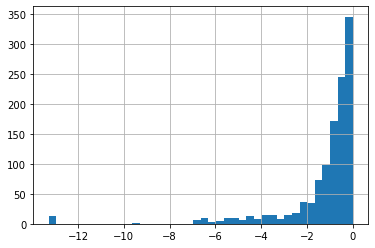

In [12]:
data_lgd["log_DLGD"] = np.log2(data_lgd['DLGD'])

data_lgd.log_DLGD.hist(bins = 40)

Summary plots

In [16]:
print(data_lgd.corr()['DLGD'])

lgd1 = data_lgd[["DLGD", "res_duration", "planned_lifetime", "realized_lifetime", "rel_realized_lifetime", 
                     "remaining_lifetime", "diff_LTV"]]
lgd2 = data_lgd[["DLGD", "LTV_time", "gdp_time", "FICO_orig_time", "recovery_res", "res_duration"]]

sns.pairplot(data_lgd)
#sns.pairplot(lgd1)
#sns.pairplot(lgd2)


id                         0.068780
time                       0.151725
orig_time                  0.287865
first_time                 0.278508
mat_time                   0.148094
res_time                   0.330550
balance_time              -0.075131
LTV_time                   0.279809
interest_rate_time         0.132749
rate_time                  0.062964
hpi_time                  -0.119237
gdp_time                  -0.183084
uer_time                   0.102508
REtype_CO_orig_time        0.041939
REtype_PU_orig_time       -0.073725
REtype_SF_orig_time        0.017528
investor_orig_time         0.088288
balance_orig_time         -0.080966
FICO_orig_time             0.043787
LTV_orig_time              0.013668
Interest_Rate_orig_time    0.113903
hpi_orig_time              0.305792
default_time                    NaN
payoff_time                     NaN
status_time                     NaN
lgd_time                   0.969606
recovery_res              -0.602406
res_duration               0

ValueError: autodetected range of [-inf, 5.20945336562895] is not finite

Summary Statistics

In [15]:
data_lgd.describe()

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,sq_diff_LTV,sq_res_duration,sq_interest_rate_time,sq_LTV_time,sq_LTV_orig_time,sq_balance_orig_time,sq_FICO_orig_time,log_res_duration,DLGD,log_DLGD
count,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1.160000e+03,1160.000000,1160.000000,1160.000000,...,1160.000000,1160.000000,1160.000000,1160.000000,1160.000000,1.160000e+03,1160.000000,1160.000000,1160.000000,1159.000000
mean,24383.927586,34.054310,22.590517,25.577586,142.310345,40.711207,2.420816e+05,96.493189,7.743166,4.650017,...,650.521861,70.658621,63.795370,9766.792150,6714.001422,8.610223e+10,430457.722414,-inf,0.597296,-1.238845
std,14252.067534,7.996957,6.319949,5.221663,13.755045,9.276421,1.691197e+05,21.360008,1.960116,0.423731,...,653.229544,119.259901,30.584918,3964.918692,1385.582816,1.306123e+11,86265.517748,NaN,0.298258,1.884193
min,191.000000,3.000000,-21.000000,1.000000,40.000000,7.000000,1.060467e+04,13.865652,2.000000,3.540000,...,0.000000,0.000000,4.000000,192.256299,2631.690000,3.422500e+08,210681.000000,-inf,-0.033736,-13.287712
25%,11906.750000,30.000000,21.000000,24.000000,141.000000,35.000000,1.170925e+05,82.808703,6.625000,4.390000,...,97.312270,9.000000,43.890625,6857.281622,6400.000000,1.452637e+10,372100.000000,1.584963,0.388588,-1.361319
50%,24616.000000,34.000000,25.000000,27.000000,144.000000,40.000000,1.989150e+05,98.335832,7.738000,4.640000,...,434.437057,25.000000,59.876788,9669.935904,6400.000000,4.000000e+10,426409.000000,2.321928,0.636635,-0.651269
75%,36152.000000,38.000000,26.000000,29.000000,147.000000,47.000000,3.209351e+05,111.964962,8.910250,4.860000,...,1059.560651,64.000000,79.392555,12536.152833,7225.000000,1.024000e+11,491401.000000,3.000000,0.842417,-0.247224
max,49174.000000,58.000000,31.000000,52.000000,189.000000,60.000000,1.317836e+06,155.613265,13.500000,7.840000,...,5702.253197,1369.000000,182.250000,24215.488256,10670.890000,1.440000e+12,660969.000000,5.209453,0.999900,-0.000144
